# <center>Datalab Cup 4: Recommender Systems</center>
<center>Shan-Hung Wu & DataLab</center>
<center>Fall 2022</center>

## 組員
朱彥如 張誠晉 蘇東誠

# Methods we have tried
1. SVD 和 Bias SVD
2. fine tune the model parameters

## Overview

In this competition, you should design a recommender system that recommends movies to users. When a user queries your system with $(UserID, Timestamp)$, your system should **return a list of 10 movies in their MovieIDs** $(MovieID_1, MovieID_2, \cdots, MovieID_{10})$ which the user might be interested in.

## Dataset

### **Please download the dataset [here.](https://drive.google.com/drive/folders/1gWrJAKSobFAVxNbEdXTUK0uH7dDFwWBo?usp=sharing)**

The dataset used in this competition is a modified version of the [MovieLens Dataset](https://grouplens.org/datasets/movielens/). **However, training your model with the original MovieLens Dataset is prohibited. You should use the one provided by us**.

The provided dataset consists of three files: `ratings_train.csv`, `users.csv`, and `movies.csv`.

### `ratings_train.csv`:
Interactions between users and movies in format $(UserID, MovieID, Rating, Timestamp)$. For each user, all interactions in this training set occur earlier than all the interactions corresponding to the same user in the testing set which we will use to evaluate your model.
- $UserID$: ID of the user.
- $MovieID$: ID of the movie.
- $Rating$: Rating score that the user gives to the movie.
- $Timestamp$: Timestamp of when the user rated the movie.

### `users.csv`:
Features of all users in format $(UserID, Gender, Age, Occupation, ZipCode)$. Includes all users in the training and the testing set.
- $UserID$: ID of the user.
- $Gender$: Gender of the user.
- $Age$: Age interval to which the user belongs. The number represents the starting age of the interval.
- $Occupation$: Occupation class number of the user.
- $ZipCode$: ZIP code string of the user.

###  `movies.csv`:
Features of all movies in format $(MovieID, Title, Genres)$. Includes all movies in the training and the testing set.
- $MovieID$: ID of the movie.
- $Title$: Title of the movie.
- $Genres$: Genres of the movie. Multiple genres are separated by `|`.

In this competition, you can implement any recommender system. Here we provide an example model which implements the simplified version of Funk-SVD mentioned in class.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Inspect the dataset
Let's load and inspect the three files `ratings_train.csv`, `users.csv`, and `movies.csv` in the dataset.

In [ ]:
cd "Competition 04"

C:\Users\Yan-Ru\Desktop\Competition 04


In [ ]:
DATASET_PATH = 'dataset'
USERS_PATH = os.path.join(DATASET_PATH, 'users.csv')
MOVIES_PATH = os.path.join(DATASET_PATH, 'movies.csv')
RATINGS_PATH = os.path.join(DATASET_PATH, 'ratings_train.csv')

In [ ]:
df_users = pd.read_csv(USERS_PATH)
df_users

,UserID,Gender,Age,Occupation,ZipCode
0,0,F,1,10,48067
1,1,M,56,16,70072
2,2,M,25,15,55117
3,3,M,45,7,02460
4,4,M,25,20,55455
...,...,...,...,...,...
6035,6035,F,25,15,32603
6036,6036,F,45,1,76006
6037,6037,F,56,1,14706
6038,6038,F,45,0,01060


In [ ]:
df_movies = pd.read_csv(MOVIES_PATH)
df_movies

,MovieID,Title,Genres
0,0,Toy Story (1995),Animation|Children's|Comedy
1,1,Jumanji (1995),Adventure|Children's|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama
4,4,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3947,Meet the Parents (2000),Comedy
3879,3948,Requiem for a Dream (2000),Drama
3880,3949,Tigerland (2000),Drama
3881,3950,Two Family House (2000),Drama


In [ ]:
df_ratings = pd.read_csv(RATINGS_PATH)
df_ratings

,UserID,MovieID,Rating,Timestamp
0,6039,857,4,956703932
1,6039,2383,4,956703954
2,6039,592,5,956703954
3,6039,1960,4,956703977
4,6039,2018,5,956703977
...,...,...,...,...
939757,5949,1996,3,1046368734
939758,5949,1260,4,1046368750
939759,5949,3151,3,1046368831
939760,5949,3910,4,1046369026


Let's calculate how many users and movies are in the dataset. Note that `users.csv` and `movies.csv` contain features for all users and movies in **both the training set and the testing set** respectively. Thus, the calculated number of users and movies covers both the training set and the testing set. Also, there are some $MovieIDs$ that do not correspond to any movie, however, we will just ignore this fact.

In [ ]:
M_USERS = max(len(df_users['UserID'].unique()), df_users['UserID'].max() + 1)
N_ITEMS = max(len(df_movies['MovieID'].unique()), df_movies['MovieID'].max() + 1)
print(f'# of users: {M_USERS}, # of movies: {N_ITEMS}')

# of users: 6040, # of movies: 3952


## Model Template
In this competition, to simulate the situation of an operating online recommender system, **we will sequentially feed the test input in ascending order of the timestamp to test your model, and we also allow you to update your model during testing**. This means your model will receive ground truth data from the testing set. To prevent disputes, we will ask you to upload your saved model to your Google Drive and submit the share link to the eeclass system, and we will then download and evaluate your model with an evaluation script. To make sure the evaluation process can be successfully executed, your model should follow the template below. Your model should inherit the `tf.keras.Model` class and at least implement the three methods: `call()`, `eval_predict_onestep()`, and `eval_update_onestep()`. Note that the `@tf.function` decorators on these methods are necessary for `model.save()` to record and save these methods.

In [ ]:
class RecommenderTemplate(tf.keras.Model):
    '''
    Template model class for competition 4
    '''

    @tf.function
    def call(self, data: tf.Tensor) -> tf.Tensor:
        '''
        Please remember to implement this method and use it by calling self() or your_model_name() at least once during training
        This method is crucial for model.save() to successfully save your model
        '''
        pass

    @tf.function
    def eval_predict_onestep(self, query: tf.Tensor) -> tf.Tensor:
        '''
        Retrieve and return the MovieIDs of the 10 recommended movies given a query
        You should return a tf.Tensor with shape=(10,)
        query will be a tf.Tensor with shape=(2,) and dtype=tf.int64
        query[0] is the UserID of the query
        query[1] is the Timestamp of the query
        Please make sure you have called this method at least once before calling model.save()
        '''
        pass

    @tf.function
    def eval_update_onestep(self, data: tf.Tensor) -> None:
        '''
        Update your model with the ground truth data of the last query
        If your model does not require test-time updating, you should still define this method and leave it empty
        data will be a tf.Tensor with shape=(4,) and dtype=tf.int64
        data[0] is the UserID
        data[1] is the MovieID 
        data[2] is the Rating
        data[3] is the Timestamp
        Please make sure you have called this method at least once before calling model.save()
        '''
        pass

## Model
Here we provide an implementation of a simplified version of the Funk-SVD model.

In [ ]:
class FunkSVDRecommender(tf.keras.Model):
    '''
    Simplified Funk-SVD recommender model
    '''

    def __init__(self, m_users: int, n_items: int, embedding_size: int, learning_rate: float):
        '''
        Constructor of the model
        '''
        super().__init__()
        self.m = m_users
        self.n = n_items
        self.k = embedding_size
        self.lr = learning_rate

        # user embeddings P
        self.P = tf.Variable(tf.keras.initializers.RandomNormal()(shape=(self.m, self.k)))

        # item embeddings Q
        self.Q = tf.Variable(tf.keras.initializers.RandomNormal()(shape=(self.n, self.k)))

        # optimizer
        self.optimizer = tf.optimizers.Adam(learning_rate=self.lr)

    @tf.function
    def call(self, user_ids: tf.Tensor, item_ids: tf.Tensor) -> tf.Tensor:
        '''
        Forward pass used in training and validating
        '''
        # dot product the user and item embeddings corresponding to the observed interaction pairs to produce predictions
        y_pred = tf.reduce_sum(tf.gather(self.P, indices=user_ids) * tf.gather(self.Q, indices=item_ids), axis=1)

        return y_pred

    @tf.function
    def compute_loss(self, y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        '''
        Compute the MSE loss of the model
        '''
        loss = tf.losses.mean_squared_error(y_true, y_pred)

        return loss

    @tf.function
    def train_step(self, data: tf.Tensor) -> tf.Tensor:
        '''
        Train the model with one batch
        data: batched user-item interactions
        each record in data is in the format [UserID, MovieID, Rating, Timestamp]
        '''
        user_ids = tf.cast(data[:, 0], dtype=tf.int32)
        item_ids = tf.cast(data[:, 1], dtype=tf.int32)
        y_true = tf.cast(data[:, 2], dtype=tf.float32)

        # compute loss
        with tf.GradientTape() as tape:
            y_pred = self(user_ids, item_ids)
            loss = self.compute_loss(y_true, y_pred)

        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return loss

    @tf.function
    def val_step(self, data: tf.Tensor) -> tf.Tensor:
        '''
        Validate the model with one batch
        data: batched user-item interactions
        each record in data is in the format [UserID, MovieID, Rating, Timestamp]
        '''
        user_ids = tf.cast(data[:, 0], dtype=tf.int32)
        item_ids = tf.cast(data[:, 1], dtype=tf.int32)
        y_true = tf.cast(data[:, 2], dtype=tf.float32)

        # compute loss
        y_pred = self(user_ids, item_ids)
        loss = self.compute_loss(y_true, y_pred)

        return loss

    @tf.function
    def eval_predict_onestep(self, query: tf.Tensor) -> tf.Tensor:
        '''
        Retrieve and return the MovieIDs of the 10 recommended movies given a query
        You should return a tf.Tensor with shape=(10,)
        query will be a tf.Tensor with shape=(2,) and dtype=tf.int64
        query[0] is the UserID of the query
        query[1] is the Timestamp of the query
        Please make sure you have called this method at least once before calling model.save()
        '''
        # dot product the selected user and all item embeddings to produce predictions
        user_id = tf.cast(query[0], tf.int32)
        y_pred = tf.reduce_sum(tf.gather(self.P, user_id) * self.Q, axis=1)

        # select the top 10 items with highest scores in y_pred
        y_top_10 = tf.math.top_k(y_pred, k=10).indices

        return y_top_10

    @tf.function
    def eval_update_onestep(self, data: tf.Tensor) -> None:
        '''
        Update your model with the ground truth data of the last query
        If your model does not require test-time updating, you should still define this method and leave it empty
        data will be a tf.Tensor with shape=(4,) and dtype=tf.int64
        data[0] is the UserID
        data[1] is the MovieID 
        data[2] is the Rating
        data[3] is the Timestamp
        Please make sure you have called this method at least once before calling model.save()
        '''
        
        user_id = tf.cast(data[0], dtype=tf.int32)
        item_id = tf.cast(data[1], dtype=tf.int32)
        y_true = tf.cast(data[2], dtype=tf.float32)

        # compute loss
        with tf.GradientTape() as tape:
            y_pred = tf.gather(self.P, user_id) * tf.gather(self.Q, item_id)
            loss = self.compute_loss(y_true, y_pred)

        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
#         pass

### Bias SVD

In [ ]:
class BIASSVDRecommender(tf.keras.Model):
    '''
    Simplified Funk-SVD recommender model
    '''

    def __init__(self, m_users: int, n_items: int, embedding_size: int, learning_rate: float, LAMBDA: float):
        '''
        Constructor of the model
        '''
        super().__init__()
        self.m = m_users
        self.n = n_items
        self.k = embedding_size
        self.lr = learning_rate
        self.LAMBDA = LAMBDA
        # user embeddings P
        self.P = tf.Variable(tf.keras.initializers.RandomNormal()(shape=(self.m, self.k)))

        # item embeddings Q
        self.Q = tf.Variable(tf.keras.initializers.RandomNormal()(shape=(self.n, self.k)))

        self.bi = tf.Variable(np.zeros(self.m)+0.01, dtype=tf.float32)
        self.bu = tf.Variable(np.zeros(self.n)+0.01, dtype=tf.float32)

        # optimizer
        self.optimizer = tf.optimizers.Adam(learning_rate=self.lr)

    @tf.function
    def call(self, user_ids: tf.Tensor, item_ids: tf.Tensor) -> tf.Tensor:
        '''
        Forward pass used in training and validating
        '''
        # dot product the user and item embeddings corresponding to the observed interaction pairs to produce predictions
        y_pred = tf.reduce_sum(tf.gather(self.P, indices=user_ids) * tf.gather(self.Q, indices=item_ids), axis=1)
        P_penalty = tf.math.reduce_sum(tf.math.square(tf.gather(self.P, indices=user_ids)), axis=1)
        #print(P_penalty.numpy().shape)
        Q_penalty = tf.math.reduce_sum(tf.math.square(tf.gather(self.Q, indices=item_ids)), axis=1)

        return y_pred, P_penalty, Q_penalty
    @tf.function
    def call2(self, user_ids: tf.Tensor, item_ids: tf.Tensor) -> tf.Tensor:
        '''
        Forward pass used in training and validating
        '''
        # dot product the user and item embeddings corresponding to the observed interaction pairs to produce predictions
        y_pred = tf.reduce_sum(tf.gather(self.P, indices=user_ids) * tf.gather(self.Q, indices=item_ids))
        P_penalty = tf.math.reduce_sum(tf.math.square(tf.gather(self.P, indices=user_ids)), axis=-1)
        #print(P_penalty.numpy().shape)
        Q_penalty = tf.math.reduce_sum(tf.math.square(tf.gather(self.Q, indices=item_ids)), axis=-1)

        return y_pred, P_penalty, Q_penalty   
      
    @tf.function
    def compute_loss(self, y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        '''
        Compute the MSE loss of the model
        '''
        loss = tf.losses.mean_squared_error(y_true, y_pred)

        return loss

    @tf.function
    def train_step(self, data: tf.Tensor, user_bias, movie_bias, mean_rating) -> tf.Tensor:
        '''
        Train the model with one batch
        data: batched user-item interactions
        each record in data is in the format [UserID, MovieID, Rating, Timestamp]
        '''
        user_ids = tf.cast(data[:, 0], dtype=tf.int32)
        item_ids = tf.cast(data[:, 1], dtype=tf.int32)
        y_true = tf.cast(data[:, 2], dtype=tf.float32)



        # compute loss
        with tf.GradientTape() as tape:
            bu = tf.gather(self.bi, user_ids.numpy())
            bi = tf.gather(self.bu, item_ids.numpy())
            y_pred1, P_penalty, Q_penalty = self(user_ids, item_ids)
            y_pred = y_pred1 + mean_rating + bu + bi
            loss = self.compute_loss(y_true, y_pred) + self.LAMBDA * (tf.math.square(bu) + tf.math.square(bi) + P_penalty + Q_penalty)
        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return loss

    @tf.function
    def val_step(self, data: tf.Tensor, user_bias, movie_bias, mean_rating) -> tf.Tensor:
        '''
        Validate the model with one batch
        data: batched user-item interactions
        each record in data is in the format [UserID, MovieID, Rating, Timestamp]
        '''
        user_ids = tf.cast(data[:, 0], dtype=tf.int32)
        item_ids = tf.cast(data[:, 1], dtype=tf.int32)
        y_true = tf.cast(data[:, 2], dtype=tf.float32)
        bu = tf.gather(self.bi, user_ids.numpy())
        bi = tf.gather(self.bu, user_ids.numpy())
        y_pred1, P_penalty, Q_penalty = self(user_ids, item_ids) 
        y_pred = y_pred1 + mean_rating + bu + bi+ self.LAMBDA * (tf.math.square(bu) + tf.math.square(bi) + P_penalty + Q_penalty)
        # compute loss
        loss = self.compute_loss(y_true, y_pred)

        return loss

    @tf.function
    def eval_predict_onestep(self, query: tf.Tensor) -> tf.Tensor:
        '''
        Retrieve and return the MovieIDs of the 10 recommended movies given a query
        You should return a tf.Tensor with shape=(10,)
        query will be a tf.Tensor with shape=(2,) and dtype=tf.int64
        query[0] is the UserID of the query
        query[1] is the Timestamp of the query
        Please make sure you have called this method at least once before calling model.save()
        '''
        # dot product the selected user and all item embeddings to produce predictions
        user_id = tf.cast(query[0], tf.int32)
        
        #pq = tf.gather(self.P, user_id) * self.Q
        #print(pq.shape)
        #print(self.bu.shape)
        #bi = tf.repeat(tf.gather(self.bi, user_id), repeats=N_ITEMS)
        #print(bi.shape)
        y_pred = tf.reduce_sum(tf.gather(self.P, user_id) * self.Q, axis=1) + self.bu + tf.repeat(tf.gather(self.bi, user_id), repeats=N_ITEMS)

        # select the top 10 items with highest scores in y_pred
        y_top_10 = tf.math.top_k(y_pred, k=10).indices

        return y_top_10

    @tf.function
    def eval_update_onestep(self, data: tf.Tensor) -> None:
        '''
        Update your model with the ground truth data of the last query
        If your model does not require test-time updating, you should still define this method and leave it empty
        data will be a tf.Tensor with shape=(4,) and dtype=tf.int64
        data[0] is the UserID
        data[1] is the MovieID 
        data[2] is the Rating
        data[3] is the Timestamp
        Please make sure you have called this method at least once before calling model.save()
        '''
        user_ids = tf.cast(data[0], dtype=tf.int32)
        item_ids = tf.cast(data[1], dtype=tf.int32)
        y_true = tf.cast(data[2], dtype=tf.float32)



        # compute loss
        with tf.GradientTape() as tape:
            bu = tf.gather(self.bi, user_ids.numpy())
            bi = tf.gather(self.bu, item_ids.numpy())
            y_pred1, P_penalty, Q_penalty = self.call2(user_ids, item_ids)
            y_pred = y_pred1 + mean_rating + bu + bi
            loss = tf.math.square(y_true - y_pred) + self.LAMBDA * (tf.math.square(bu) + tf.math.square(bi) + P_penalty + Q_penalty)
        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

## Split datasets
Since the testing set is not provided, splitting a validation set is highly recommended. We recommend first creating per-user validation sets with the latest interactions of each user (should also contain sufficient positive interactions), then joining all small validation sets to form a complete validation set since this is the exact way the testing set is created.

In [ ]:
# interactions with rating >= 4 are positive interactions
POSITIVE_THRESHOLD = 4 

# each per-user validation set should contain at least 5 positive interactions
POSITIVE_PER_USER = 5

train_dataframes = []
val_dataframes = []

for i in tqdm(range(M_USERS)):
    user_all = df_ratings[df_ratings['UserID'] == i]
    user_positive = user_all[user_all['Rating'] >= POSITIVE_THRESHOLD]

    # check if there are enough positive interactions to build a validation set for this user
    if len(user_positive) >= POSITIVE_PER_USER:
        split_idx = user_positive.iloc[-POSITIVE_PER_USER].name
        user_train = user_all.loc[:split_idx]
        user_test = user_all.loc[split_idx:]
        assert user_train['Timestamp'].max() <= user_test['Timestamp'].min()
        train_dataframes.append(user_train)
        val_dataframes.append(user_test)
    else:
        train_dataframes.append(user_all)

# concat all per-user training sets
df_train = pd.concat(train_dataframes).sort_values(by='Timestamp', ascending=True, ignore_index=True)

# normalize the ratings (may be beneficial to some models)
df_train_norm = df_train
df_train_norm['Rating'] -= 3
df_train_norm['Rating'] /= 2

# concat all per-user validation sets
df_val = pd.concat(val_dataframes).sort_values(by='Timestamp', ascending=True, ignore_index=True)

# normalize the ratings (may be beneficial to some models)
# here we make a copy of the un-normalized validation set for evaluation
df_val_norm = df_val.copy(deep=True)
df_val_norm['Rating'] -= 3
df_val_norm['Rating'] /= 2

100%|██████████| 6040/6040 [00:09<00:00, 606.63it/s]


## Whole dataset

In [ ]:
whole = []
for i in tqdm(range(M_USERS)):
    user_all = df_ratings[df_ratings['UserID'] == i]
    whole.append(user_all)
df_whole = pd.concat(whole).sort_values(by='Timestamp', ascending=True, ignore_index=True)
df_whole_norm = df_whole
df_whole_norm['Rating'] -= 3
df_whole_norm['Rating'] /= 2

100%|██████████| 6040/6040 [00:06<00:00, 919.61it/s]


In [ ]:
df_train_norm

,UserID,MovieID,Rating,Timestamp
0,6039,857,0.5,956703932
1,6039,592,1.0,956703954
2,6039,2383,0.5,956703954
3,6039,2018,1.0,956703977
4,6039,1960,0.5,956703977
...,...,...,...,...
893652,5949,2857,0.0,1046368290
893653,5949,2663,0.0,1046368398
893654,5949,1299,0.5,1046368398
893655,5949,1195,0.5,1046368417


In [ ]:
df_val_norm

,UserID,MovieID,Rating,Timestamp
0,6038,2018,0.5,956706538
1,6038,1251,0.5,956706538
2,6038,922,0.5,956706538
3,6037,2715,0.0,956707604
4,6037,3547,0.5,956707604
...,...,...,...,...
52084,5949,1996,0.0,1046368734
52085,5949,1260,0.5,1046368750
52086,5949,3151,0.0,1046368831
52087,5949,3910,0.5,1046369026


In [ ]:
df_whole_norm

,UserID,MovieID,Rating,Timestamp
0,6039,857,0.5,956703932
1,6039,2383,0.5,956703954
2,6039,592,1.0,956703954
3,6039,1960,0.5,956703977
4,6039,2018,1.0,956703977
...,...,...,...,...
939757,5949,1996,0.0,1046368734
939758,5949,1260,0.5,1046368750
939759,5949,3151,0.0,1046368831
939760,5949,3910,0.5,1046369026


## Evaluation metric
For the evaluation metric, we will use a modified version of $NDCG@10$ specifically for this task to evaluate the performance of your model.

$$
NDCG@10 =
    \begin{cases}
        \frac{1}{log_2(i_A+1)}, & \text{if $A \in \textbf{Y}$, where $A$ is the ground truth item, $\textbf{Y}$ is the predicted items, and $i_A$ is the index of $A$ in $\textbf{Y}$}\\
        0, & \text{otherwise}\\
    \end{cases}
$$

Also, $Recall@10$ (same as $HitRate@10$ in this task) will be calculated. However, it is just for your reference and does not account for the performance score.

While evaluating your test performance, we will use an evaluation procedure very similar to the `evaluate()` function below. However, the `evaluate()` function provided here is just for validating your training performance.

For all evaluation rounds, we will ask you to upload your saved model to your Google Drive and submit the share link to the eeclass system, and we will then download and evaluate your model with an evaluation script. A download link to a sample evaluation script that uses part of the training set is provided [here](https://drive.google.com/file/d/1QDB41a3K66f5XW3M_FSqjG1tgyU6NqPa/view?usp=sharing). Please make sure your saved model can be loaded and evaluated by the sample evaluation script. Note that the evaluation procedure will not provide any features of the users and the movies. If you want to use them during evaluation, you should store them in your model while training.

**Note that we define an interaction as positive if its rating is >= 4. For score calculating, e.g., $NDCG@10$, we will only invoke your model to make recommendations for queries that the ground truth interaction is positive. However, since neutral or negative interactions may still aid your model, we will invoke your model to perform the evaluation-stage update regardless of the ratings of the data points.**

In [ ]:
@tf.function
def log2(x: tf.Tensor) -> tf.Tensor:
    return tf.math.log(tf.cast(x, tf.float32)) / tf.math.log(2.)

@tf.function
def ndcg_at_10(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    y_pred = y_pred[:10]
    idx = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
    if tf.reduce_sum(tf.cast(idx, tf.int32)) > 0:
        return 1. / log2(2 + tf.argmax(idx))
    else:
        return tf.constant(0.)

@tf.function
def recall_at_10(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    y_pred = y_pred[:10]
    idx = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
    if tf.reduce_sum(tf.cast(idx, tf.int32)) > 0:
        return tf.constant(1.)
    else:
        return tf.constant(0.)

def evaluate(model: tf.keras.Model, dataset: tf.data.Dataset) -> tuple:
    '''
    For each data point in the dataset:
    data[0] is the UserID
    data[1] is the MovieID 
    data[2] is the Rating
    data[3] is the Timestamp
    '''
    ndcg_scores = []
    recall_scores = []

    for data in tqdm(dataset, desc='Evaluating'):
        # query the model to make predictions if the observed event is a positive interaction (ratings >= 4)
        if data[2] >= 4:
            y_pred = model.eval_predict_onestep(tf.gather(data, (0, 3)))
            y_true = tf.gather(data, 1)
            ndcg = ndcg_at_10(y_true, y_pred)
            recall = recall_at_10(y_true, y_pred)
            ndcg_scores.append(ndcg)
            recall_scores.append(recall)

        # update the model with the observerd event
        model.eval_update_onestep(data)

    ndcg_result = tf.reduce_mean(ndcg_scores).numpy()
    recall_result = tf.reduce_mean(recall_scores).numpy()

    return ndcg_result, recall_result

## Train the model

### Funk SVD

In [ ]:
# hyperparameters
EMBEDDING_SIZE = 1536
BATCH_SIZE = 1024
N_EPOCHS = 10
LEARNING_RATE = 1e-4

Epoch 1:


Validating: 100%|██████████| 51/51 [00:00<00:00, 398.08it/s]


Epoch 1 train_loss: 0.4096, val_loss: 0.3994

Epoch 2:


Validating: 100%|██████████| 51/51 [00:00<00:00, 849.21it/s]


Epoch 2 train_loss: 0.3830, val_loss: 0.3911

Epoch 3:


Validating: 100%|██████████| 51/51 [00:00<00:00, 835.29it/s]


Epoch 3 train_loss: 0.3484, val_loss: 0.3746

Epoch 4:


Validating: 100%|██████████| 51/51 [00:00<00:00, 878.50it/s]


Epoch 4 train_loss: 0.2990, val_loss: 0.3436

Epoch 5:


Validating: 100%|██████████| 51/51 [00:00<00:00, 878.51it/s]


Epoch 5 train_loss: 0.2367, val_loss: 0.3042

Epoch 6:


Validating: 100%|██████████| 51/51 [00:00<00:00, 863.61it/s]


Epoch 6 train_loss: 0.1830, val_loss: 0.2737

Epoch 7:


Validating: 100%|██████████| 51/51 [00:00<00:00, 878.48it/s]


Epoch 7 train_loss: 0.1492, val_loss: 0.2561

Epoch 8:


Validating: 100%|██████████| 51/51 [00:00<00:00, 796.13it/s]


Epoch 8 train_loss: 0.1263, val_loss: 0.2454

Epoch 9:


Validating: 100%|██████████| 51/51 [00:00<00:00, 863.63it/s]


Epoch 9 train_loss: 0.1077, val_loss: 0.2382

Epoch 10:


Validating: 100%|██████████| 51/51 [00:00<00:00, 878.51it/s]


Epoch 10 train_loss: 0.0915, val_loss: 0.2332



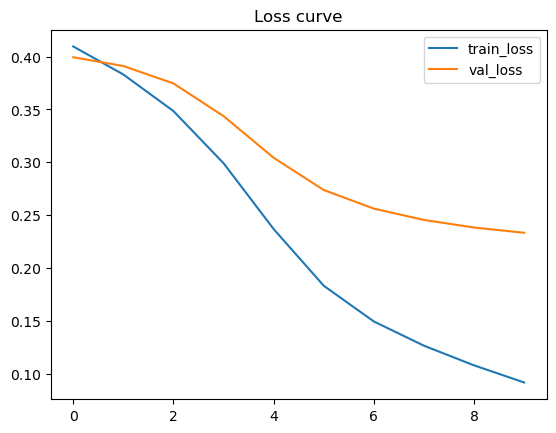

In [ ]:
# prepare datasets
dataset_train = tf.data.Dataset.from_tensor_slices(df_train_norm)
dataset_train = dataset_train.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

dataset_val = tf.data.Dataset.from_tensor_slices(df_val_norm)
dataset_val = dataset_val.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

# build the model
model = FunkSVDRecommender(m_users=M_USERS, n_items=N_ITEMS, embedding_size=EMBEDDING_SIZE, learning_rate=LEARNING_RATE)

# train the model
train_losses = []
val_losses = []

for epoch in range(1, N_EPOCHS + 1):
    train_loss = []
    val_loss = []
    print(f'Epoch {epoch}:')

    # training
    for data in tqdm(dataset_train, desc='Training'):
        loss = model.train_step(data)
        train_loss.append(loss.numpy())

    # validating
    for data in tqdm(dataset_val, desc='Validating'):
        loss = model.val_step(data)
        val_loss.append(loss.numpy())

    # record losses
    avg_train_loss = np.mean(train_loss)
    avg_val_loss = np.mean(val_loss)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print losses
    print(f'Epoch {epoch} train_loss: {avg_train_loss:.4f}, val_loss: {avg_val_loss:.4f}\n')

# plot the training curve
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss curve')
plt.show()

### Bias SVD

In [ ]:
# interactions with rating >= 4 are positive interactions
import pdb
POSITIVE_THRESHOLD = 4 

# each per-user validation set should contain at least 6 positive interactions
POSITIVE_PER_USER = 5

movie_bias = []
for i in tqdm(range(N_ITEMS)):
    movie_all = df_ratings[df_ratings['MovieID'] == i]
    movie_bias.append(np.mean(movie_all['Rating'].values)) 


train_dataframes = []
val_dataframes = []
user_bias = []
for i in tqdm(range(M_USERS)):
    user_all = df_ratings[df_ratings['UserID'] == i] # find all rating record the user have done
    user_bias.append(np.mean(user_all['Rating'].values)) 
    user_positive = user_all[user_all['Rating'] >= POSITIVE_THRESHOLD]
    #pdb.set_trace()
    # check if there are enough positive interactions to build a validation set for this user
    if len(user_positive) >= POSITIVE_PER_USER:
        split_idx = user_positive.iloc[-POSITIVE_PER_USER].name
        user_train = user_all.loc[:split_idx]
        user_test = user_all.loc[split_idx:]
        #pdb.set_trace()
        assert user_train['Timestamp'].max() <= user_test['Timestamp'].min() # all the training rating are older than the testing rating
        train_dataframes.append(user_train)
        val_dataframes.append(user_test)
    else:
        train_dataframes.append(user_all)

# concat all per-user training sets
df_train = pd.concat(train_dataframes).sort_values(by='Timestamp', ascending=True, ignore_index=True)

# normalize the ratings (may be beneficial to some models)
df_train_norm = df_train
df_train_norm['Rating'] -= 3 # -2 -1 0 1 2 
df_train_norm['Rating'] /= 2 # -1 -0.5 0 0.5 1

# concat all per-user validation sets
df_val = pd.concat(val_dataframes).sort_values(by='Timestamp', ascending=True, ignore_index=True)

# normalize the ratings (may be beneficial to some models)
# here we make a copy of the un-normalized validation set for evaluation
df_val_norm = df_val.copy(deep=True)
df_val_norm['Rating'] -= 3
df_val_norm['Rating'] /= 2

# bias
user_bias = (np.array(user_bias) -3)/2
movie_bias = np.nan_to_num((np.array(movie_bias) -3)/2) # nan to zero
user_bias = user_bias - np.mean(user_bias)
movie_bias = movie_bias - np.mean(movie_bias)
mean_rating = np.mean(df_train_norm['Rating'].values)

  0%|          | 0/3952 [00:00<?, ?it/s]C:\Users\Yan-Ru\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yan-Ru\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6040/6040 [00:10<00:00, 567.78it/s]


In [ ]:
# hyperparameters
EMBEDDING_SIZE = 4096
BATCH_SIZE = 4096
N_EPOCHS = 57
LEARNING_RATE = 1e-4
LAMBDA_ = 1e-2
# prepare datasets
dataset_train = tf.data.Dataset.from_tensor_slices(df_train_norm)
dataset_train = dataset_train.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

dataset_val = tf.data.Dataset.from_tensor_slices(df_val_norm)
dataset_val = dataset_val.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

# build the model
model = BIASSVDRecommender(m_users=M_USERS, n_items=N_ITEMS, embedding_size=EMBEDDING_SIZE, learning_rate=LEARNING_RATE, LAMBDA=LAMBDA_)

# train the model
train_losses = []
val_losses = []

for epoch in range(1, N_EPOCHS + 1):
    train_loss = []
    val_loss = []
    print(f'Epoch {epoch}:')

    # training
    for data in tqdm(dataset_train, desc='Training'):
        loss = model.train_step(data, user_bias, movie_bias, mean_rating)
        #print(loss.shape)
        train_loss.append(np.mean(loss.numpy()))

    # validating
    for data in tqdm(dataset_val, desc='Validating'):
        loss = model.val_step(data, user_bias, movie_bias, mean_rating)
        val_loss.append(np.mean(loss.numpy()))

    # record losses
    avg_train_loss = np.mean(train_loss)
    #print(avg_train_loss.shape)
    avg_val_loss = np.mean(val_loss)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print losses
    print(f'Epoch {epoch} train_loss: {avg_train_loss:.4f}, val_loss: {avg_val_loss:.4f}\n')

# plot the training curve
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss curve')
plt.show()

Epoch 1:


Training:   0%|          | 0/219 [00:00<?, ?it/s]


AttributeError: in user code:

    File "C:\Users\Yan-Ru\AppData\Local\Temp\ipykernel_15436\2208523230.py", line 77, in train_step  *
        bu = tf.gather(self.bi, user_ids.numpy())

    AttributeError: 'Tensor' object has no attribute 'numpy'


## Evaluate the model with the validation set

This part is just for you to check the validation performance. We will use a private testing set to evaluate the performance of your model.

### Bias SVD
1. 
* EMBEDDING_SIZE = 256
* BATCH_SIZE = 4096
* N_EPOCHS = 60
* LEARNING_RATE = 1e-4
* LAMBDA_ = 1e-2
* Evaluation result: [NDCG@10: 0.020109, Recall@10: 0.039739]
2. 
* EMBEDDING_SIZE = 256
* BATCH_SIZE = 4096
* N_EPOCHS = 60
* LEARNING_RATE = 1e-4
* LAMBDA_ = 1e-3
* Evaluation result: [NDCG@10: 0.019667, Recall@10: 0.039104]
3. 
* (2) with eval_update_onestep
* Evaluating: 100%|██████████| 52089/52089 [19:17<00:00, 45.00it/s]
* Evaluation result: [NDCG@10: 0.021574, Recall@10: 0.042413]
4. 
* EMBEDDING_SIZE = 2048
* BATCH_SIZE = 4096
* N_EPOCHS = 100
* LEARNING_RATE = 1e-4
* LAMBDA_ = 1e-2
* Evaluating: 100%|██████████| 52089/52089 [19:28<00:00, 44.58it/s]
* Evaluation result: [NDCG@10: 0.024689, Recall@10: 0.049766]
5. 
* EMBEDDING_SIZE = 4096
* BATCH_SIZE = 4096
* N_EPOCHS = 60
* LEARNING_RATE = 1e-4
* LAMBDA_ = 1e-2
* Evaluating: 100%|██████████| 52089/52089 [20:26<00:00, 42.46it/s]
* Evaluation result: [NDCG@10: 0.024880, Recall@10: 0.049967]
6. 可以嘗試更大的embedding

### Funk SVD

* Batch size=1024
* Learning rate=$10^{-4}$

In [ ]:
dataset_eval = tf.data.Dataset.from_tensor_slices(df_val)
dataset_eval = dataset_eval.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@10: {ndcg_result:.6f}, Recall@10: {recall_result:.6f}]')

Evaluating: 100%|██████████| 52089/52089 [03:38<00:00, 238.04it/s]


Evaluation result: [NDCG@10: 0.025551, Recall@10: 0.049632]


* Batch size=1024
* Learning rate=$10^{-5}$

In [ ]:
dataset_eval = tf.data.Dataset.from_tensor_slices(df_val)
dataset_eval = dataset_eval.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@10: {ndcg_result:.6f}, Recall@10: {recall_result:.6f}]')

Evaluating: 100%|██████████| 52089/52089 [03:33<00:00, 244.30it/s]


Evaluation result: [NDCG@10: 0.002123, Recall@10: 0.004579]


* Batch size=1024
* Learning rate=$10^{-3}$

In [ ]:
dataset_eval = tf.data.Dataset.from_tensor_slices(df_val)
dataset_eval = dataset_eval.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@10: {ndcg_result:.6f}, Recall@10: {recall_result:.6f}]')

Evaluating: 100%|██████████| 52089/52089 [03:34<00:00, 242.41it/s]


Evaluation result: [NDCG@10: 0.024544, Recall@10: 0.046491]


* Embedding size=1024
* Batch size=1024
* Learning rate=$10^{-4}$

In [ ]:
dataset_eval = tf.data.Dataset.from_tensor_slices(df_val)
dataset_eval = dataset_eval.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@10: {ndcg_result:.6f}, Recall@10: {recall_result:.6f}]')

Evaluating: 100%|██████████| 52089/52089 [03:12<00:00, 271.03it/s]


Evaluation result: [NDCG@10: 0.026029, Recall@10: 0.050668]


* with eval_update_onestep()
* Embedding size=1024
* Batch size=1024
* Learning rate=$10^{-4}$

In [ ]:
dataset_eval = tf.data.Dataset.from_tensor_slices(df_val)
dataset_eval = dataset_eval.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@10: {ndcg_result:.6f}, Recall@10: {recall_result:.6f}]')

Evaluating: 100%|██████████| 52089/52089 [07:00<00:00, 123.78it/s]


Evaluation result: [NDCG@10: 0.026105, Recall@10: 0.051170]


* with eval_update_onestep()
* Embedding size=2048
* Batch size=1024
* Learning rate=$10^{-4}$

In [ ]:
dataset_eval = tf.data.Dataset.from_tensor_slices(df_val)
dataset_eval = dataset_eval.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@10: {ndcg_result:.6f}, Recall@10: {recall_result:.6f}]')

Evaluating: 100%|██████████| 52089/52089 [10:31<00:00, 82.42it/s]


Evaluation result: [NDCG@10: 0.025549, Recall@10: 0.050602]


* Epoch number=30
* with eval_update_onestep()
* Embedding size=1024
* Batch size=1024
* Learning rate=$10^{-4}$

In [ ]:
dataset_eval = tf.data.Dataset.from_tensor_slices(df_val)
dataset_eval = dataset_eval.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@10: {ndcg_result:.6f}, Recall@10: {recall_result:.6f}]')

Evaluating: 100%|██████████| 52089/52089 [08:49<00:00, 98.43it/s] 


Evaluation result: [NDCG@10: 0.026151, Recall@10: 0.051939]


* Epoch number=200
* with eval_update_onestep()
* Embedding size=1536
* Batch size=1024
* Learning rate=$10^{-4}$

In [ ]:
dataset_eval = tf.data.Dataset.from_tensor_slices(df_val)
dataset_eval = dataset_eval.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@10: {ndcg_result:.6f}, Recall@10: {recall_result:.6f}]')

Evaluating: 100%|██████████| 52089/52089 [08:45<00:00, 99.13it/s] 


Evaluation result: [NDCG@10: 0.026767, Recall@10: 0.053676]


* Epoch number=20
* with eval_update_onestep()
* Embedding size=1536
* Batch size=1024
* Learning rate=$10^{-4}$

In [ ]:
dataset_eval = tf.data.Dataset.from_tensor_slices(df_val)
dataset_eval = dataset_eval.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@10: {ndcg_result:.6f}, Recall@10: {recall_result:.6f}]')

Evaluating: 100%|██████████| 52089/52089 [08:43<00:00, 99.50it/s] 


Evaluation result: [NDCG@10: 0.026764, Recall@10: 0.052340]


* Epoch number=40
* with eval_update_onestep()
* Embedding size=1536
* Batch size=1024
* Learning rate=$10^{-4}$

In [ ]:
dataset_eval = tf.data.Dataset.from_tensor_slices(df_val)
dataset_eval = dataset_eval.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@10: {ndcg_result:.6f}, Recall@10: {recall_result:.6f}]')

Evaluating: 100%|██████████| 52089/52089 [08:46<00:00, 98.91it/s] 


Evaluation result: [NDCG@10: 0.026137, Recall@10: 0.051070]


### The best for the 4 th round

* Epoch number=10
* with eval_update_onestep()
* Embedding size=1536
* Batch size=1024
* Learning rate=$10^{-4}$

In [ ]:
dataset_eval = tf.data.Dataset.from_tensor_slices(df_val)
dataset_eval = dataset_eval.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@10: {ndcg_result:.6f}, Recall@10: {recall_result:.6f}]')

Evaluating: 100%|██████████| 52089/52089 [08:53<00:00, 97.69it/s] 


Evaluation result: [NDCG@10: 0.027105, Recall@10: 0.053309]


## train complete dataset

Epoch 1:


Training: 100%|██████████| 918/918 [00:08<00:00, 105.84it/s]


Epoch 1 train_loss: 0.4082

Epoch 2:


Training: 100%|██████████| 918/918 [00:07<00:00, 116.10it/s]


Epoch 2 train_loss: 0.3814

Epoch 3:


Training: 100%|██████████| 918/918 [00:07<00:00, 116.61it/s]


Epoch 3 train_loss: 0.3461

Epoch 4:


Training: 100%|██████████| 918/918 [00:07<00:00, 116.81it/s]


Epoch 4 train_loss: 0.2952

Epoch 5:


Training: 100%|██████████| 918/918 [00:07<00:00, 116.05it/s]


Epoch 5 train_loss: 0.2320

Epoch 6:


Training: 100%|██████████| 918/918 [00:07<00:00, 116.49it/s]


Epoch 6 train_loss: 0.1798

Epoch 7:


Training: 100%|██████████| 918/918 [00:07<00:00, 116.64it/s]


Epoch 7 train_loss: 0.1473

Epoch 8:


Training: 100%|██████████| 918/918 [00:07<00:00, 116.35it/s]


Epoch 8 train_loss: 0.1246

Epoch 9:


Training: 100%|██████████| 918/918 [00:07<00:00, 115.96it/s]


Epoch 9 train_loss: 0.1059

Epoch 10:


Training: 100%|██████████| 918/918 [00:07<00:00, 115.98it/s]


Epoch 10 train_loss: 0.0895



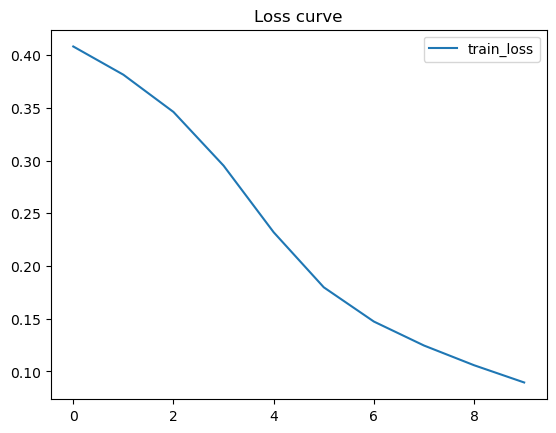

In [ ]:
# prepare datasets
dataset_whole = tf.data.Dataset.from_tensor_slices(df_whole_norm)
dataset_whole = dataset_whole.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

# build the model
model = FunkSVDRecommender(m_users=M_USERS, n_items=N_ITEMS, embedding_size=EMBEDDING_SIZE, learning_rate=LEARNING_RATE)

# train the model
train_losses = []
val_losses = []

for epoch in range(1, N_EPOCHS + 1):
    train_loss = []
    val_loss = []
    print(f'Epoch {epoch}:')

    # training
    for data in tqdm(dataset_whole, desc='Training'):
        loss = model.train_step(data)
        train_loss.append(loss.numpy())

    # record losses
    avg_train_loss = np.mean(train_loss)
    train_losses.append(avg_train_loss)

    # print losses
    print(f'Epoch {epoch} train_loss: {avg_train_loss:.4f}\n')

# plot the training curve
plt.plot(train_losses, label='train_loss')
plt.legend(loc='upper right')
plt.title('Loss curve')
plt.show()

In [ ]:
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@10: {ndcg_result:.6f}, Recall@10: {recall_result:.6f}]')

Evaluating: 100%|██████████| 52089/52089 [09:00<00:00, 96.34it/s] 


Evaluation result: [NDCG@10: 0.076209, Recall@10: 0.156517]


## Save the model

Please remember to save your model and make sure the saved model can be loaded and evaluated by the sample evaluation script provided [here](https://drive.google.com/file/d/1QDB41a3K66f5XW3M_FSqjG1tgyU6NqPa/view?usp=sharing).

We recommend you first evaluate your model with the `evaluate()` function defined above, then save your model. This ensures the custom methods `eval_predict_onestep()` and `eval_update_onestep()` are both called and tracked.

In [ ]:
# save the model
model.save('funksvd_model')

INFO:tensorflow:Assets written to: funksvd_model\assets


INFO:tensorflow:Assets written to: funksvd_model\assets


# <center>Precautions</center>

## What you should do in this competition

### 0. Design a recommender system that recommends movies to users.

When a user queries your system with $(UserID, Timestamp)$, your system should **return a list of 10 movies in their MovieIDs** $(MovieID_1, MovieID_2, \cdots, MovieID_{10})$ which the user might be interested in.

### 1. Download the dataset [here](https://drive.google.com/drive/folders/1gWrJAKSobFAVxNbEdXTUK0uH7dDFwWBo?usp=sharing) and the sample evaluation script [here](https://drive.google.com/file/d/1QDB41a3K66f5XW3M_FSqjG1tgyU6NqPa/view?usp=sharing).

Please refer to the previous part of the notebook for more detail about the dataset.

### 2. Implement and train a recommender system with the provided dataset. Your model should follow the template below.

In this competition, to simulate the situation of an operating online recommender system, **we will sequentially feed the test input in ascending order of the timestamp to test your model, and we also allow you to update your model during testing**. This means your model will receive ground truth data from the testing set. To prevent disputes, we will ask you to upload your saved model to your Google Drive and submit the share link to the eeclass system, and we will then download and evaluate your model with an evaluation script. To make sure the evaluation process can be successfully executed, your model should follow the template below. Your model should inherit the `tf.keras.Model` class and at least implement the three methods: `call()`, `eval_predict_onestep()`, and `eval_update_onestep()`. Note that the `@tf.function` decorators on these methods are necessary for `model.save()` to record and save these methods.

Note: Since the evaluation script will not provide user and movie features while testing your model, you should save these features in your model during training if you utilize them in `eval_predict_onestep()` or `eval_update_onestep()`.

In [ ]:
class RecommenderTemplate(tf.keras.Model):
    '''
    Template model class for competition 4
    '''

    @tf.function
    def call(self, data: tf.Tensor) -> tf.Tensor:
        '''
        Please remember to implement this method and use it by calling self() or your_model_name() at least once during training
        This method is crucial for model.save() to successfully save your model
        '''
        pass

    @tf.function
    def eval_predict_onestep(self, query: tf.Tensor) -> tf.Tensor:
        '''
        Retrieve and return the MovieIDs of the 10 recommended movies given a query
        You should return a tf.Tensor with shape=(10,)
        query will be a tf.Tensor with shape=(2,) and dtype=tf.int64
        query[0] is the UserID of the query
        query[1] is the Timestamp of the query
        Please make sure you have called this method at least once before calling model.save()
        '''
        pass

    @tf.function
    def eval_update_onestep(self, data: tf.Tensor) -> None:
        '''
        Update your model with the ground truth data of the last query
        If your model does not require test-time updating, you should still define this method and leave it empty
        data will be a tf.Tensor with shape=(4,) and dtype=tf.int64
        data[0] is the UserID
        data[1] is the MovieID 
        data[2] is the Rating
        data[3] is the Timestamp
        Please make sure you have called this method at least once before calling model.save()
        '''
        pass

### 3. Save your entire model with `model.save()` and verify if it can be loaded and evaluated by the sample evaluation script.

To execute the sample evaluation script, type the command below (please replace the paths with actual values):

```
python evaluate_sample.py [path to ratings_train.csv] [path to your saved model]
```

If you have tried your best debugging but still failed to make the evaluation script evaluate your model successfully, please contact the TAs with the eeclass discussion forum.

### 4. Participate in evaluation rounds **(One submission per group in each round)**.

To evaluate your model, we will use a private testing set and an evaluation script similar to the provided sample evaluation script to test your model. There will be three evaluation rounds, and **we will use the same testing set in all rounds**.

For each evaluation round, we will open an eeclass assignment for submission. You should upload your model to your Google Drive and submit the share link to the corresponding assignment. The first two evaluation rounds are optional. However, **all groups should submit your model in the final evaluation round. Only the model performance in the final evaluation round will account for your score.**

The deadline for model submission in the final evaluation round is 2023/01/13 (Fri) 23:59 (UTC+8).

### 5. Write a report after the final evaluation (One report per group).

Your report should contain:
- Models you have tried during the competition. Please briefly describe the main idea of the model and the reason why you chose that model.
- List the experiments you have done. For instance, data preprocessing, hyperparameters tuning, architecture tuning, optimizer tuning, and so on.
- Discussions, lessons learned, or anything else worth mentioning.

The deadline for report submission is 2023/01/15 (Sun) 23:59 (UTC+8).

## What you can do
- Implement any recommender model with any packages in TensorFlow 2.
- **Train your recommender model with the provided dataset from scratch**.
- Update your model during evaluation by implementing `eval_update_onestep()`.
- Save the user and movie features in your model since we will not provide them during evaluation.
- You can use a pretrained text encoder if you need text embeddings. **(This is the only place you can use a pretrained model in this competition)**

## What you CAN NOT do
- **Use any dataset other than the provided one. Using any official MovieLens datasets is also prohibited.**
- **Use any pretrained recommender models.**
- Plagiarize other teams' work.
- Hack or crash our evaluation platform with your submitted saved models.

## Scoring

- $NDCG@10$ ranking of the **final evaluation round** (80%)
- Report (20%)

## Important dates
- 2022/12/29 (Thur): Competition starts
- 2023/01/03 (Tue): First round of evaluation (optional)
- 2023/01/08 (Sun): Second round of evaluation (optional)
- 2023/01/13 (Fri): Final round of evaluation **(mandatory)**
- 2023/01/15 (Sun): Report submission
- 2023/01/17 (Tue): Competition 4 showoff